# Test de visualisation de dataframe avec panda

Et voir si on peut utiliser cela pour visualiser les dataset RDF dans DBnary.

Il est donc facile d'afficher des graphiques avec des données sous forme de dataframe panda.

La question devient donc, comment créer un dataframe panda à partir d'un datacube RDF.

Hélas, le projet pandardf semble n'être qu'une doc de comment faire... rien de fonctionnel

**Conclusion**: essayer de faire une page dataviz avec nodejs...

# Lecture des stats de DBnary avec pandas 

Il est possible d'utiliser une requête adhoc pour récupérer les statistiques de DBnary (stockées en DataCube/RDF) en un csv qui peut facilement être affiché.

Les différentes requêtes sont : 

### Statistiques générales de la dernière version


In [16]:
latest_general_stats_query="""SELECT ?Language
        (sample(?maxversion) as ?Version)
        (sample(?num_entries) as ?Entries)
        (sample(?num_pages) as ?Vocables)
        (sample(?num_senses) as ?Senses)
        (sample(?num_translations) as ?Translations)
WHERE
{
    {
     # Select the latest version
     SELECT distinct(?version) as ?maxversion
     WHERE { ?s dbnary:wiktionaryDumpVersion ?version . }
     ORDER BY DESC(?version) LIMIT 1
    }

    ?obs
        qb:dataSet dbnstats:dbnaryStatisticsCube ;
        dbnary:observationLanguage ?Language ;
        dbnary:lexicalEntryCount ?num_entries ;
        dbnary:pageCount ?num_pages ;
        dbnary:lexicalSenseCount ?num_senses ;
        dbnary:translationsCount ?num_translations ;
        dbnary:wiktionaryDumpVersion ?maxversion .
}
GROUP BY ?Language
ORDER BY ?Language"""

### Statistiques des traductions de la dernière version

In [17]:
latest_translation_stats_query="""SELECT ?Language
      (sample(?maxversion) as ?Version)
        (sample(?deuCount) as ?deu)
        (sample(?ellCount) as ?ell)
        (sample(?engCount) as ?eng)
        (sample(?finCount) as ?fin)
        (sample(?fraCount) as ?fra)
        (sample(?itaCount) as ?ita)
        (sample(?jpnCount) as ?jpn)
        (sample(?porCount) as ?por)
        (sample(?rusCount) as ?rus)
        (sample(?turCount) as ?tur)
        (sample(?othersCount) as ?others)
        (sample(?totalCount) as ?total)
        (sample(?langCount) as ?number_of_languages)
WHERE {
    {
     # Select the latest version
     SELECT distinct(?version) as ?maxversion
     WHERE { ?s dbnary:wiktionaryDumpVersion ?version ; qb:dataSet dbnstats:dbnaryNymRelationsCube . }
     ORDER BY DESC(?version) LIMIT 1
    }

    ?obs
        qb:dataSet dbnstats:dbnaryTranslationsCube ;
        dbnary:observationLanguage ?Language ;
        dbnary:wiktionaryDumpVersion ?maxversion .

        { ?obs dbnary:nymRelation dbnary:synonym ; dbnary:count ?synCount. }
        UNION { ?obs lime:language "de" ; dbnary:count ?deuCount . }
        UNION { ?obs lime:language "el" ; dbnary:count ?ellCount . }
        UNION { ?obs lime:language "en" ; dbnary:count ?engCount . }
        UNION { ?obs lime:language "fi" ; dbnary:count ?finCount . }
        UNION { ?obs lime:language "fr" ; dbnary:count ?fraCount . }
        UNION { ?obs lime:language "it" ; dbnary:count ?itaCount . }
        UNION { ?obs lime:language "ja" ; dbnary:count ?jpnCount . }
        UNION { ?obs lime:language "pt" ; dbnary:count ?porCount . }
        UNION { ?obs lime:language "ru" ; dbnary:count ?rusCount . }
        UNION { ?obs lime:language "tr" ; dbnary:count ?turCount . }
        UNION { ?obs lime:language "others" ; dbnary:count ?othersCount . }
        UNION { ?obs lime:language "mul" ; dbnary:count ?totalCount . }
        UNION { ?obs lime:language "number_of_languages" ; dbnary:count ?langCount . }

} GROUP by ?Language
ORDER BY ?Language"""


### Latest lexical relations statistics

In [18]:
latest_nym_stats_query="""SELECT ?Language (sample(?maxversion) as ?Version)
        (sample(?synCount) as ?syn)
        (sample(?qsynCount) as ?qsyn)
        (sample(?antCount) as ?ant)
        (sample(?hyperCount) as ?hyper)
        (sample(?hypoCount) as ?hypo)
        (sample(?meroCount) as ?mero)
        (sample(?holoCount) as ?holo)
        (sample(?tropoCount) as ?tropo)
WHERE {
    {
     # Select the latest version
     SELECT distinct(?version) as ?maxversion
     WHERE { ?s dbnary:wiktionaryDumpVersion ?version ; qb:dataSet dbnstats:dbnaryNymRelationsCube . }
     ORDER BY DESC(?version) LIMIT 1
    }

    ?obs
        qb:dataSet dbnstats:dbnaryNymRelationsCube ;
        dbnary:observationLanguage ?Language ;
        dbnary:wiktionaryDumpVersion ?maxversion .

        { ?obs dbnary:nymRelation dbnary:synonym ; dbnary:count ?synCount. }
        UNION { ?obs dbnary:nymRelation dbnary:approximateSynonym ; dbnary:count ?qsynCount. }
        UNION { ?obs dbnary:nymRelation dbnary:antonym ; dbnary:count ?antCount. }
        UNION { ?obs dbnary:nymRelation dbnary:hypernym ; dbnary:count ?hyperCount. }
        UNION { ?obs dbnary:nymRelation dbnary:hyponym ; dbnary:count ?hypoCount. }
        UNION { ?obs dbnary:nymRelation dbnary:meronym ; dbnary:count ?meroCount. }
        UNION { ?obs dbnary:nymRelation dbnary:holonym ; dbnary:count ?holoCount. }
        UNION { ?obs dbnary:nymRelation dbnary:troponym ; dbnary:count ?tropoCount. }

} GROUP by ?Language
ORDER BY ?Language"""

## Querying the DBnary SPARQL datapoint using the preceding queries

### Setup and utility functions

In [22]:
import urllib
import io

class DBnaryStatsQuery:

    # Utility function to wrap the query in a url.
    def __get_query_url(self, query: str) :
        return self.endpoint + '?' + urllib.parse.urlencode({
                'query' : query,
                'format': 'text/csv'
            })

    def __init__(self, query: str,  endpoint, index:str='Language',):
        self.query = query
        self.index = index
        self.endpoint = endpoint
        self.url = self.__get_query_url(self.query)
        self.dataframe = None

    def get_csv(self) :
        r = urllib.request.urlopen(self.url)
        if r.getcode() == 200:
            return io.BytesIO(r.read())
        else:
            return ""
        
    def get_dataframe(self):
        if self.dataframe is None :
            self.dataframe = pd.read_csv(self.get_csv(), index_col='Language')
        return self.dataframe
        

class DBnary:
    default_endpoint = "http://kaiko.getalp.org/sparql"

    def __createQuery(self, sparql: str, index='Language'):
        return DBnaryStatsQuery(sparql, index=index, endpoint=self.endpoint)

    def __init__(self, endpoint=default_endpoint):
        self.endpoint = endpoint
        self.latest_general = self.__createQuery(latest_general_stats_query)
        self.latest_translations = self.__createQuery(latest_translation_stats_query)
        self.latest_nyms = self.__createQuery(latest_nym_stats_query)

dbnary = DBnary()


,Entries,Vocables,Senses,Translations
Language,,,,
bg,18735,27095,18523,15535
de,173975,299642,168469,689989
el,553959,533341,246944,167386
en,1007606,957009,785380,2490684
es,93686,97901,129755,168469


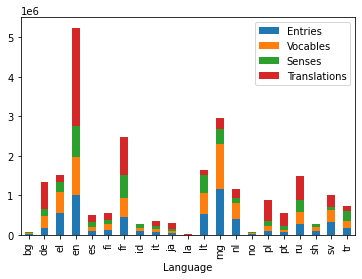

In [25]:
data = dbnary.latest_general.get_dataframe()
data = data.drop('Version', 1)
data.head(5)
data.plot.bar(stacked=True);